In [69]:
data_dir = 'L:/DATA/ISIS/keras_ocr/'

import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf

import keras_ocr

## Train the recognizer
After some research, training the detector seems hard and time consuming, so we'll start by training the recognizer with our own pictures. To train the recognizer, we need small images of digits from ionograms. I cropped 60 ionograms and their metadata. Each of them looks like this.

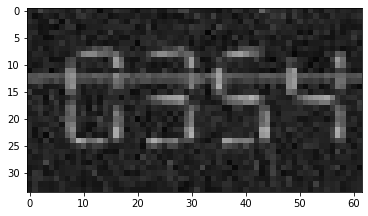

In [70]:
im = plt.imread(data_dir+'test_images/cropped/1-5.jpg')
plt.imshow(im)

I also created a txt file with the name of the images and the right numbers. I looks like this.

In [71]:
import pandas as pd

dataset = pd.read_csv(data_dir+'test_images/cropped/annotations.txt', header=None, 
                      names=['file','text'], dtype={'file' : str, 'text' : str})
dataset['file'] = data_dir+'test_images/cropped/' + dataset['file']
dataset['text'] = dataset['text'].astype(str)
dataset.insert(1, 'empty', None)

dataset.head(6)

,file,empty,text
0,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-1...,None,36
1,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-2...,None,00
2,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-3...,None,69
3,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-4...,None,11
4,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-5...,None,0354
5,L:/DATA/ISIS/keras_ocr/test_images/cropped/1-5...,None,35


In [72]:
train_subset, test_subset = sklearn.model_selection.train_test_split(dataset, test_size=0.2)

train_subset.reset_index(inplace=True, drop=True)
test_subset.reset_index(inplace=True, drop=True)

train = []
for i in range(len(train_subset)):
    train.append(tuple(train_subset.loc[i].to_list()))

test = []
for i in range(len(test_subset)):
    test.append(tuple(test_subset.loc[i].to_list()))

In [2]:
'''train_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='train',
    cache_dir=data_dir
)
test_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='test',
    cache_dir=data_dir
)
train_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]
test_labels = [(filepath, box, word.lower()) for filepath, box, word in test_labels]'''

Looking for L:/DATA/ISIS/keras_ocr\borndigital\Challenge1_Training_Task3_Images_GT.zip
Looking for L:/DATA/ISIS/keras_ocr\borndigital\Challenge1_Test_Task3_Images.zip
Looking for L:/DATA/ISIS/keras_ocr\borndigital\test\Challenge1_Test_Task3_GT.txt


In [73]:
import string
recognizer = keras_ocr.recognition.Recognizer(alphabet=string.digits)
recognizer.compile()

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for C:\Users\mfortier\.keras-ocr\crnn_kurapan_notop.h5


In [74]:
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

#train_labels, validation_labels = sklearn.model_selection.train_test_split(train, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train, augmenter), (test, None)]
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

144 / 144 instances have illegal characters.
text: 72


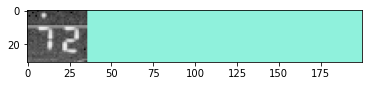

In [75]:
image, text = next(training_image_gen)
print('text:', text)
plt.imshow(image)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]
recognizer.training_model.fit(
    training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=1000,
    workers=0,
    batch_size=batch_size
)

Epoch 1/1000
18/18 [==============================] - 106s 5s/step - loss: 14.1516 - val_loss: 6.6492
Epoch 2/1000
18/18 [==============================] - 97s 6s/step - loss: 6.5643 - val_loss: 5.2139
Epoch 3/1000
18/18 [==============================] - 119s 7s/step - loss: 4.8950 - val_loss: 3.7188
Epoch 4/1000
18/18 [==============================] - 105s 6s/step - loss: 2.2596 - val_loss: 1.4244
Epoch 5/1000
18/18 [==============================] - 110s 6s/step - loss: 1.5996 - val_loss: 1.1311
Epoch 6/1000
18/18 [==============================] - 81s 4s/step - loss: 0.8263 - val_loss: 0.6778
Epoch 7/1000
18/18 [==============================] - 89s 5s/step - loss: 0.7277 - val_loss: 0.6577
Epoch 8/1000
18/18 [==============================] - 96s 5s/step - loss: 0.3337 - val_loss: 0.6087
Epoch 9/1000
18/18 [==============================] - 88s 5s/step - loss: 0.4507 - val_loss: 0.4440
Epoch 10/1000
18/18 [==============================] - 80s 5s/step - loss: 0.2100 - val_loss: 0

1/1 [==============================] - 2s 2s/step
Predicted: 2525, Actual: developer


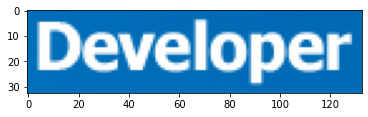

In [46]:
image_filepath, _, actual = test_labels[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

Looking for C:\Users\mfortier\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 5s 5s/step


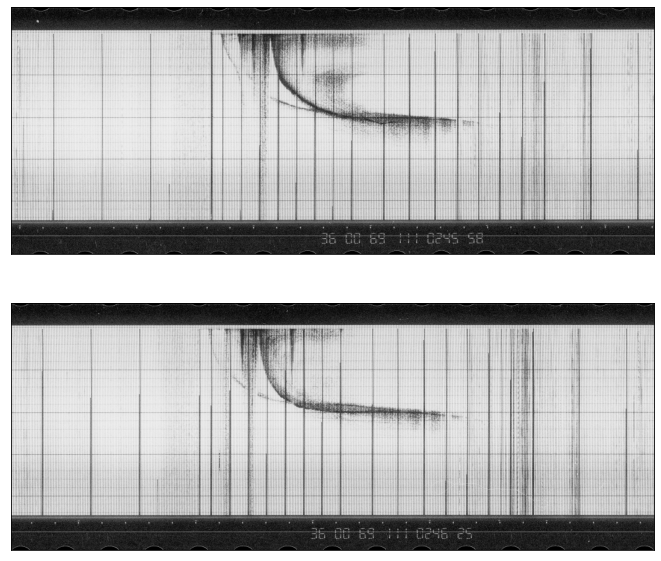

In [11]:
subdir_path = 'L:/DATA/ISIS/raw_upload_20230421/R014207869/B1-34-49 ISIS-A C-198-00/'
pipeline = keras_ocr.pipeline.Pipeline(detector=detector)
images = [keras_ocr.tools.read(img) for img in [subdir_path + 'Image0005.png',subdir_path + 'Image0006.png']]
prediction_groups = pipeline.recognize(images)
# plot the text predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(15, 10))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, 
                                    predictions=predictions, 
                                    ax=ax)